## Data Summary  
#### Import Python Lirbaries

In [45]:
# Import core libraries and ML utilities
import os
import glob
import gc
import warnings
import re
import random
import math
import json
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

#### Import Datasets

In [2]:
# Paths to data folders and labels file
train_images_path = './train/'
test_images_path  = './test/'
train_labels_csv  = './train/train_labels.csv'

# Load training labels
labels_df = pd.read_csv(train_labels_csv)

# Create a list of the file paths to the images in the train and test folders
train_file_paths = glob.glob(os.path.join(train_images_path, '*.tif'))
test_file_paths = glob.glob(os.path.join(test_images_path, '*.tif'))

print(f'Count of train images = {len(train_file_paths):,}\nCount of test images = {len(test_file_paths):,}')

Count of train images = 220,025
Count of test images = 57,458


#### Configure Constant Variables
- Define the exogenous varibles that will be used throughout the modeling and analysis.

In [3]:
# Image config
IMG_SIZE = 96 # Target size to resize images to
CHANNELS = 3  # RGB images
SAMPLE_SIZE = 100 # Number of image samples used for training

# Tensorflow pipeline config
# GPU_dict = {'RTX 3050 Ti':50, 'GC T4 GPU':80, 'GC TPU':64} # Dictionary used to choose GPU type (Local GPU vs Google Colab GPU/TPU)
# SHARD_SIZE = round(len(train_file_paths) / GPU_dict['RTX 3050 Ti']) # The number of tf.train.Examples per TFRecord shard
BATCH_SIZE = 64 # Training batch size
AUTOTUNE = tf.data.AUTOTUNE # Let tf.data choose parallelism
MAX_EPOCHS = 3

# Ignore warnings
warnings.simplefilter('ignore')

#### Check Image Sizes
- Ensure all of the images are 96 x 96 pixels with 3 channels (red, green, blue)

In [4]:
skip = True
def check_image_sizes(folder):
    bad_files = []
    if skip == False:
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            with tiff.TiffFile(path) as img:
                h, w, c = img.pages[0].shape
            if h != IMG_SIZE or w != IMG_SIZE or c != CHANNELS:
                bad_files.append(f)
    if len(bad_files)<=0 or skip==True:
        print(f'All {len(os.listdir(folder)):,} .tif files in the {folder} folder are {IMG_SIZE} x {IMG_SIZE} pixels with {CHANNELS} channels.')
    else:
        print(f"Found {len(bad_files)} files not matching image sizes of {IMG_SIZE} x {IMG_SIZE} x {CHANNELS}:")
        print(bad_files)

check_image_sizes(train_images_path)
check_image_sizes(test_images_path)

All 220,026 .tif files in the ./train/ folder are 96 x 96 pixels with 3 channels.
All 57,458 .tif files in the ./test/ folder are 96 x 96 pixels with 3 channels.


## Exploratory Data Analysis (EDA)
In this section I inspect the data visually and numerically. I load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, I am using the Pillow library to read them. I also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

#### Sample of Training Data Images
- Visualize a samples of images from both the positive and negative labels

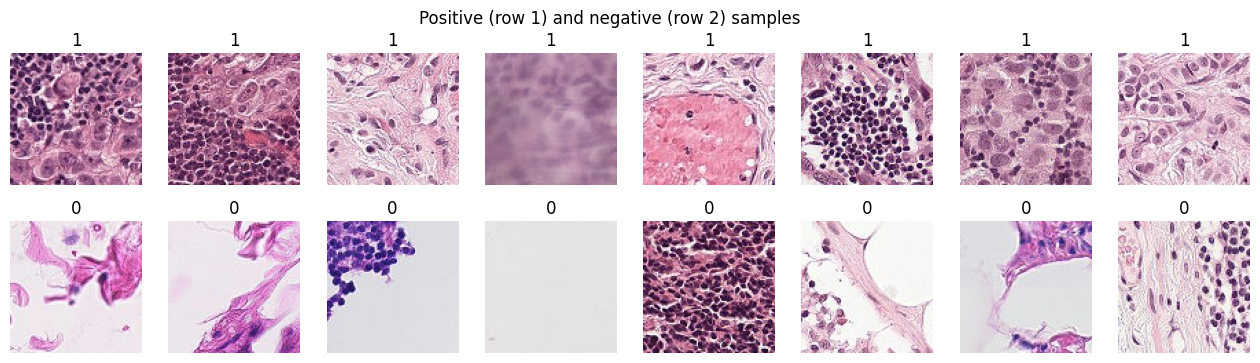

In [5]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_images_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_images_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

#### RGB Channels
- The data is provided as images broken out into 3 channels: red, green, blue (RGB). This visualizes how the RGB channels are combined to create the orignial image.

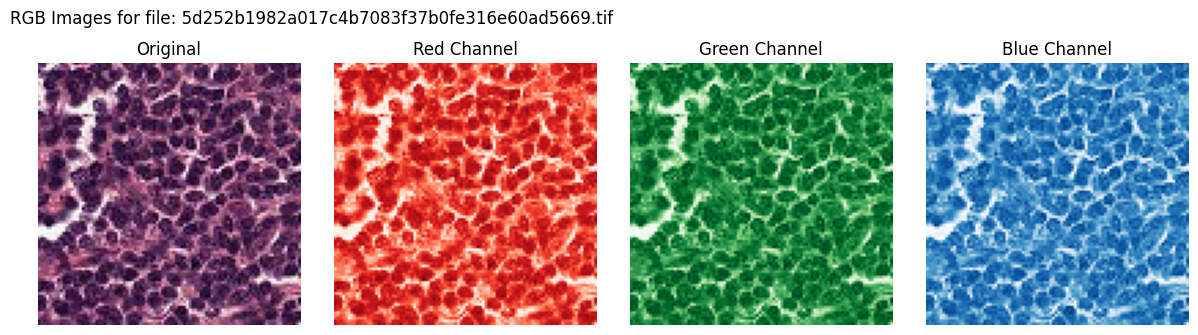

In [6]:
# Randomly select a training image
rand_idx = random.randint(0, len(os.listdir(train_images_path))+1)
filename = os.listdir(train_images_path)[rand_idx]

# Path to one example image
img_path = os.path.join(train_images_path, filename)

# Read the image (as NumPy array)
img = tiff.imread(img_path)

# Display each channel with its color
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ['Original', 'Red Channel', 'Green Channel', 'Blue Channel']
cmaps  = [None, 'Reds_r', 'Greens_r', 'Blues_r']

# Plot original RGB + individual color channels
axes[0].imshow(img)
axes[0].set_title(titles[0])
axes[0].axis('off')
for i, (title, cmap) in enumerate(zip(titles[1:], cmaps[1:])):
    axes[i+1].imshow(img[:, :, i], cmap=cmap)
    axes[i+1].set_title(title)
    axes[i+1].axis('off')
plt.tight_layout()
plt.suptitle(f'RGB Images for file: {filename}', y=1.1, horizontalalignment='right')
plt.show()

#### RGB Histograms by Label
- This plot compares the aggregated distributions of each RGB color channel for a sample of images

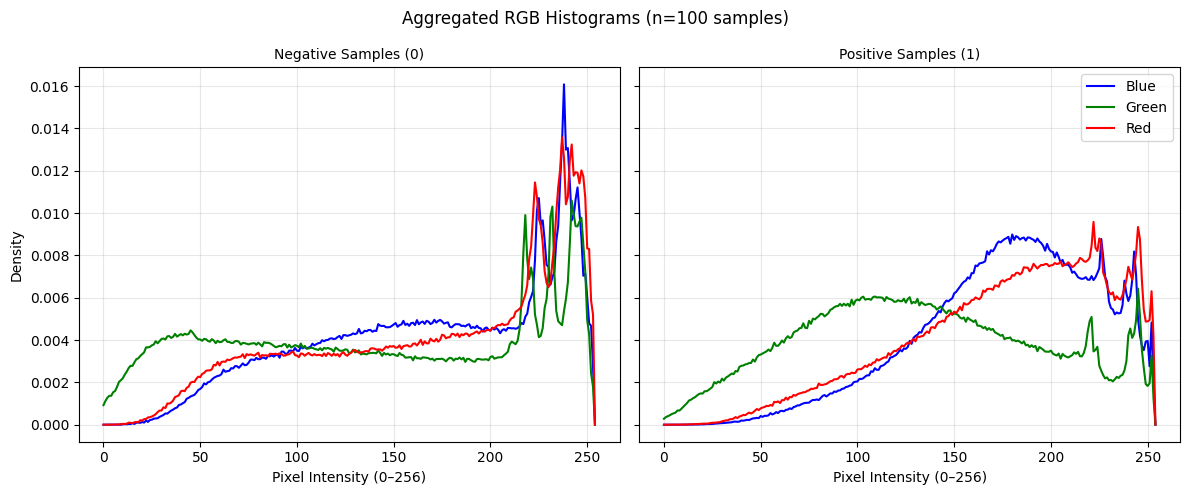

In [7]:
# Choose a random set of files from the positive (1) and negative (0) labels
n = SAMPLE_SIZE
positive_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==1]['id'].sample(n).to_list()]
negative_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==0]['id'].sample(n).to_list()]

# Function to create RGB histogram data
def get_histogram_data(files):
    hists = np.zeros((3, 255), dtype=np.float64)
    for path in files:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        for ch in range(3):
            hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
    return hists

# Get histogram data
negative_files_hist_data = get_histogram_data(negative_files)
positive_files_hist_data = get_histogram_data(positive_files)

negative_files_probability_data = negative_files_hist_data / negative_files_hist_data.sum(axis=1, keepdims=True)
positive_files_probability_data = positive_files_hist_data / positive_files_hist_data.sum(axis=1, keepdims=True)

# Plot RGB Histograms
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

ax0.plot(negative_files_probability_data[0], 'b', label='Blue')
ax0.plot(negative_files_probability_data[1], 'g', label='Green')
ax0.plot(negative_files_probability_data[2], 'r', label='Red')
ax0.set_title('Negative Samples (0)', fontdict={'fontsize':10})
ax0.set_xlabel('Pixel Intensity (0–256)')
ax0.set_ylabel('Density')
ax0.grid(True, alpha=0.3)

ax1.plot(positive_files_probability_data[0], 'b', label='Blue')
ax1.plot(positive_files_probability_data[1], 'g', label='Green')
ax1.plot(positive_files_probability_data[2], 'r', label='Red')
ax1.set_title('Positive Samples (1)', fontdict={'fontsize':10})
ax1.set_xlabel('Pixel Intensity (0–256)')
ax1.grid(True, alpha=0.3)
ax1.legend()

plt.suptitle(f'Aggregated RGB Histograms (n={n:,} samples)')
plt.tight_layout()
plt.show()

> The negative (non-cancerous) samples show sharp peaks in all three color channels near the high-intensity range (~230–250), suggesting brighter and more saturated regions, while the positive (cancerous) samples exhibit broader, smoother distributions with greater intensity spread—particularly elevated blue and green channel densities in mid-intensity ranges—indicating darker, less saturated tissue structures consistent with malignant patterns.

#### Distribution of Labels
- Visualize whether the dataset has a balanced distribution between negative (0) and positive (1) labels. To mitigate bias during training, I may explore class weighting or resampling strategies.

Class counts:
label
0    130908
1     89117
Name: count, dtype: int64


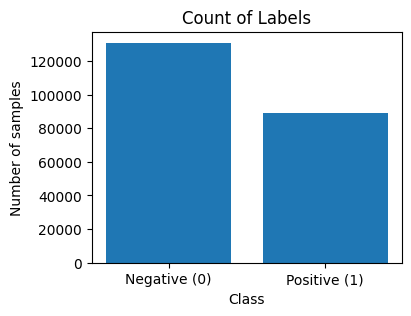

In [8]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

# Plot label distribution
plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Count of Labels')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

> The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive). This is not significant enough to affect the CNN modeling.

#### Create Training, Validation, and Test Datasets
- The Kaggle dataset only provides labels for the training images, so we will need to subdivide the training images into training (80%) and validation sets (20%) in order to be able to test the performace of the CNN models.
- I've converted the train and validation images into TensorFlow `tf.data.Dataset` objects for efficient parallel loading and model training.

In [54]:
# Load training dataset labels
train_labels_df = pd.read_csv('./train/train_labels.csv')

# Take random samples from the train_labels_df (to reduce training time)
train_labels_df = train_labels_df.sample(SAMPLE_SIZE)
test_ids_list = random.sample(test_file_paths, SAMPLE_SIZE)

# Training-Validation split
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['label'])

# Create file paths list after train-validation split
train_paths = ['./train/' + id + '.tif' for id in train_df['id']]
val_paths = ['./train/' + id + '.tif' for id in val_df['id']]

# Create label vectors after train-validation split
training_labels = train_df['label'].values
validation_labels = val_df['label'].values

# Numpy function used to read and resize images
def _read_and_resize(path):
    path = path.decode('utf-8')
    img = tiff.imread(path)       
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img.astype(np.float32)

#Function to load and preprocess each image
def load_image(path, label):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    label = tf.cast(label, tf.int32)
    return img, label

#Function to load and preprocess each image
def load_train_image(path):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    return img

# Create training and validation tf.data.Dataset instances
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, training_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, validation_labels))

# Create the test set
test_ds = tf.data.Dataset.from_tensor_slices((test_ids_list))

# Create training dataset
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nTraining dataset of {len(training_labels):,} images has been created.')

# Create validation dataset
val_ds = (
    val_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nValidation dataset of {len(validation_labels):,} images has been created.')

# Create validation dataset
test_ds = (
    test_ds
    .map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nTesting dataset of {len(test_ids_df):,} images has been created.')


Training dataset of 80 images has been created.

Validation dataset of 20 images has been created.

Testing dataset of 100 images has been created.


#### Analysis Plan

Based on the exploratory data analysis (EDA), the following insights inform our approach:
- The dataset exhibits a moderate class imbalance; techniques such as class weighting or oversampling may be beneficial for improving model sensitivity to positive (cancerous) samples, though these will not be applied initially.
- Images show noticeable staining variability and occasional artefacts, suggesting that data augmentation (random flips, rotations, and brightness/contrast adjustments) could enhance model generalisation.

Planned analysis steps:
1. ***Data Splitting***: Divide the labelled dataset into training (80%) and validation (20%) subsets to enable model evaluation on unseen data.
2. ***Preprocessing***: Resize all images to 96×96 pixels, apply real-time data augmentation, and normalise pixel values using global channel statistics.
3. ***Baseline Model***: Develop and train an initial CNN architecture, evaluating performance on the validation set using metrics suited for imbalanced data (AUC, precision, recall, and F1-score).
4. ***Hyperparameter Tuning***: Optimise parameters such as learning rate, optimiser type, dropout rate, batch size, and network depth, then assess improvements in key performance metrics.
5. ***Transfer Learning***: Train advanced CNN models (e.g., ResNet50 and DenseNet169) to leverage pre-trained feature extraction.
6. ***Model Comparison***: Compare baseline, tuned, and transfer learning models to determine which configuration provides the best balance of accuracy, generalisation, and robustness.

## CNN Modeling
The modeling process follows a structured, incremental approach to progressively improve performance and generalisation:
1. ***Baseline Model***: Develop and train a custom CNN architecture from scratch to establish a performance benchmark on the validation dataset.
2. ***Hyperparameter Optimization***: Systematically tune key parameters such as learning rate, optimiser, dropout rate, batch size, and convolutional depth to enhance the baseline model’s accuracy and robustness.
3. ***Transfer Learning Models***: Implement and fine-tune pre-trained architectures (e.g., ResNet50, DenseNet169) to leverage learned image features and accelerate convergence.
4. ***Model Evaluation***: Evaluate all models using consistent performance metrics (AUC, accuracy, precision, recall, and F1-score) and confusion matricies to identify the best-performing architecture for cancer classification.

#### Model Fitting & Evaluations Helper Functions
- The `fit_CNN_model` function trains a CNN while automatically managing early stopping, checkpointing, and logging. It reloads existing best weights if available, fits the model on the training and validation datasets, and returns the training history for analysis.
- The `evaluation_outputs` function assesses model performance by generating predictions on the validation set, computing key metrics (ROC AUC and classification report), and visualizing results through a confusion matrix and learning curves for accuracy, loss, and AUC across training epochs.

In [10]:
# Function used to fit the model
def fit_CNN_model(model, train_dataset, val_dataset, n_train=None, n_val=None, batch_size=BATCH_SIZE):
    # Create a checkpoint file which stores best model weights
    os.makedirs('./best_model_weights/', exist_ok=True)
    checkpoint_path = f'./best_model_weights/{model.name}_best_model.weights.h5'
    csv_path = f'./best_model_weights/{model.name}_model_history.csv'

    # Configure callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.CSVLogger(csv_path, append=os.path.exists(csv_path))
    ]
    # Fit CNN model
    if os.path.exists(checkpoint_path):
        model.load_weights(checkpoint_path)
        print(f'Loaded existing weights from {checkpoint_path}')

    history = model.fit(
        train_dataset,
        epochs=MAX_EPOCHS,
        steps_per_epoch=math.ceil(n_train / batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(n_val / batch_size),
        callbacks=callbacks,
        verbose=1,
    )

    return history

# Function used to create evaluation outputs
def evaulation_outputs(model, model_history, validation_dataset):
    # Predict validation probabilites
    validation_probabilities = model.predict(validation_dataset, verbose=1).ravel()

    # Convert probabilites to binary labels
    validation_predicted_labels = (validation_probabilities >= 0.5).astype(np.int32)

    # Print AUC and classification report
    print(f'\nROC AUC: {roc_auc_score(validation_labels, validation_probabilities)}\n')
    print(classification_report(validation_labels, validation_predicted_labels, digits=4))

    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(
        confusion_matrix(validation_labels, validation_predicted_labels), 
        annot=True, 
        fmt='d',
        cmap='viridis',
        cbar=False,
        xticklabels=['Negative Samples (0)','Positive Samples (1)'],
        yticklabels=['Negative Samples (0)','Positive Samples (1)'],
        square=True
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Validation Confusion Matrix\n{model.name}')
    plt.tight_layout()
    plt.show()

    # Plot the learning curves
    fig, axs = plt.subplots(1, 3, figsize = (15,5))
    axs[0].set_title('Accuracy')
    axs[0].plot(model_history.epoch, model_history.history['accuracy'], label = 'Training Accuracy')
    axs[0].plot(model_history.epoch, model_history.history['val_accuracy'], label = 'Validation Accuracy')
    axs[0].legend()

    axs[1].set_title('Loss')
    axs[1].plot(model_history.epoch, model_history.history['loss'], label = 'Training Loss')
    axs[1].plot(model_history.epoch, model_history.history['val_loss'], label = 'Validation Loss')
    axs[1].legend()

    axs[2].set_title('AUC')
    axs[2].plot(model_history.epoch, model_history.history['auc'], label = 'Training AUC')
    axs[2].plot(model_history.epoch, model_history.history['val_auc'], label = 'Validation AUC')
    axs[2].legend()

#### Baseline CNN Model
- The baseline CNN model includes data augmentation, normalization, and three convolution–pooling blocks that progressively extract spatial features. The extracted features are flattened using global average pooling and passed through dense layers with dropout regularization before producing a final sigmoid output for binary cancer prediction.

In [11]:
# Function to create an instance of baseline CNN model
def build_baseline_cnn(model_name, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dropout_rate=0.5):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name='augmentation')

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = aug(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

# Create the baseline model instance
baseline_cnn_model = build_baseline_cnn('Baseline_CNN_Model')
baseline_cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

# Display baseline model structure
baseline_cnn_model.summary()

Model: "Baseline_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Loaded existing weights from ./best_model_weights/Baseline_CNN_Model_best_model.weights.h5
Epoch 1/3


2025-11-04 19:18:31.345531: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 857ms/step - accuracy: 0.8875 - auc: 0.9273 - loss: 0.3361 - val_accuracy: 0.8500 - val_auc: 1.0000 - val_loss: 0.3007
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8625 - auc: 0.9185 - loss: 0.3494 - val_accuracy: 0.9000 - val_auc: 0.9780 - val_loss: 0.2750
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8625 - auc: 0.9456 - loss: 0.3006 - val_accuracy: 0.8000 - val_auc: 0.9615 - val_loss: 0.3120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

ROC AUC: 1.0

              precision    recall  f1-score   support

           0     0.8125    1.0000    0.8966        13
           1     1.0000    0.5714    0.7273         7

    accuracy                         0.8500        20
   macro avg     0.9062    0.7857    0.8119        20
weighted avg     0.8781    0.8500    0.8373        20



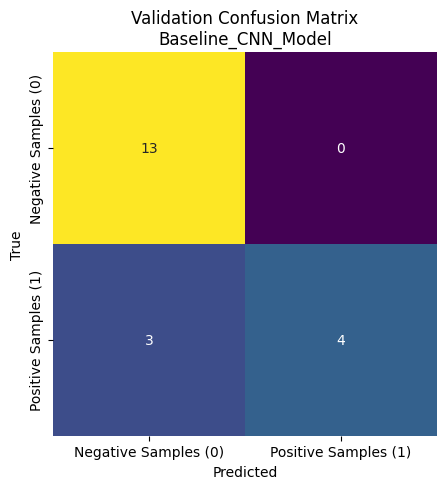

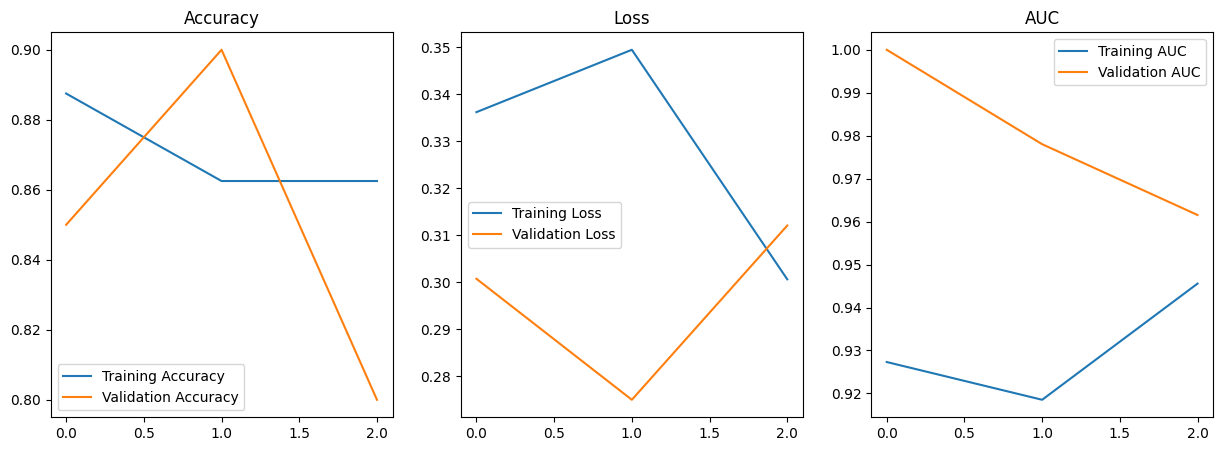

In [12]:
# Fit the baseline model
baseline_history = fit_CNN_model(
    baseline_cnn_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(baseline_cnn_model, baseline_history, val_ds)

> Somthing about baseline model results...

## Hyperparmeter Tuning
- Next I tune the hyperparameters of the baseline CNN using Keras Tuner to identify the optimal **learning rate** and **dropout rate** for improved model performance.

#### Tuning Dropout & Learning Rates

In [13]:
# Tuning model_builder config
def model_builder(hp):
    tf.keras.backend.clear_session()
    gc.collect()
    hp_learning_rate = hp.Choice('learning_rate', [1e-4, 3e-4, 1e-3])
    hp_dropout = hp.Float('dropout', 0.3, 0.7, step=0.1)
    model = build_baseline_cnn('Tuned_Baseline_CNN_Model', input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=hp_dropout)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['auc', 'accuracy']
    )
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_auc',
    max_trials=1,
    executions_per_trial=1,
    overwrite=True,
    directory='./tuning/',
    project_name='hyperparameter_tuning_results'
)

# Run tuner on base model
tuner.search(train_ds, validation_data=val_ds, epochs=5)

# Get best dropout and learning rates
best_learning_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
best_dropout_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('dropout')
print(f'\nAfter hyperparameter tuning the best learning rate is {best_learning_rate} and the best dropout rate is {best_dropout_rate}.')

Trial 1 Complete [00h 00m 04s]
val_auc: 0.7087912559509277

Best val_auc So Far: 0.7087912559509277
Total elapsed time: 00h 00m 04s

After hyperparameter tuning the best learning rate is 0.0001 and the best dropout rate is 0.3.


#### Apply Best Learning & Dropout Rates to Baseline CNN Model

In [14]:
# Create the baseline model instance
tuned_baseline_cnn_model = build_baseline_cnn('Tuned_Baseline_CNN_Model', dropout_rate=best_dropout_rate)
tuned_baseline_cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

# Display baseline model structure
tuned_baseline_cnn_model.summary()

Model: "Tuned_Baseline_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Loaded existing weights from ./best_model_weights/Tuned_Baseline_CNN_Model_best_model.weights.h5
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5875 - auc: 0.4740 - loss: 0.6849 - val_accuracy: 0.6500 - val_auc: 0.5495 - val_loss: 0.6710
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6125 - auc: 0.5345 - loss: 0.6768 - val_accuracy: 0.6500 - val_auc: 0.5714 - val_loss: 0.6635
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6375 - auc: 0.4959 - loss: 0.6716 - val_accuracy: 0.6500 - val_auc: 0.6264 - val_loss: 0.6576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

ROC AUC: 0.6373626373626373

              precision    recall  f1-score   support

           0     0.6500    1.0000    0.7879        13
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.6500        20
   macro avg     0.3250    0.5000    0.3939        20
weighted avg     0.4225    0.6500    0.5121        20



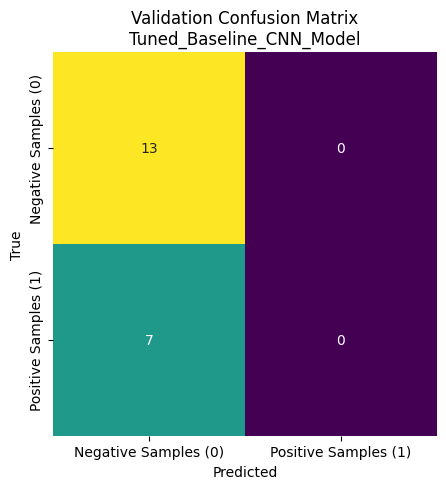

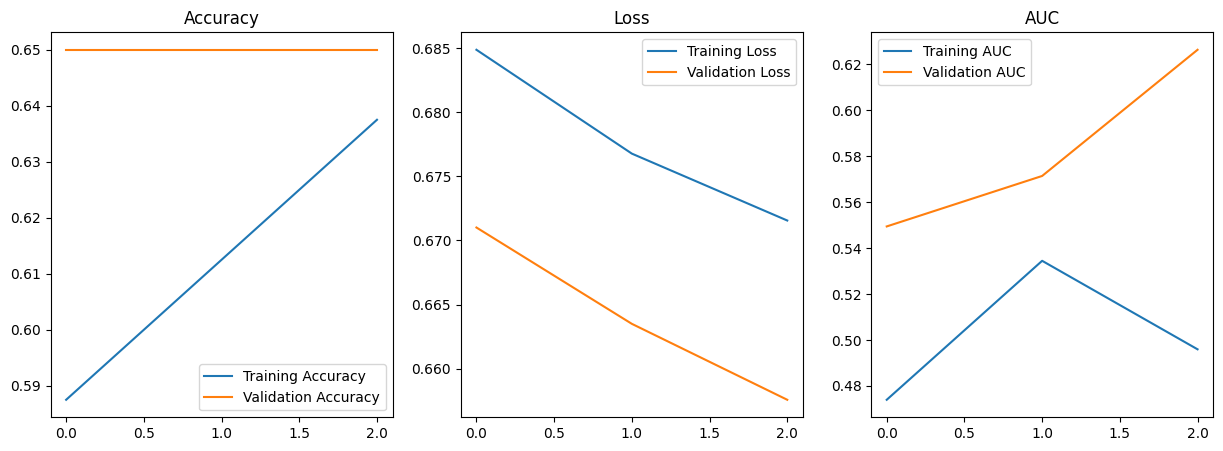

In [16]:
# Fit the baseline model
tuned_baseline_cnn_model_history = fit_CNN_model(
    tuned_baseline_cnn_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(tuned_baseline_cnn_model, tuned_baseline_cnn_model_history, val_ds)

## CNN Transfer Models
- **ResNet50** and *DenseNet169* are deep convolutional neural network architectures pre-trained on large datasets such as ImageNet.
  - ResNet50 (Residual Network with 50 layers) uses skip connections to allow gradients to flow through the network more effectively, solving the vanishing gradient problem and enabling very deep models to learn efficiently.
  - DenseNet169 (Densely Connected Network with 169 layers) connects each layer to every other layer in a feed-forward fashion, promoting feature reuse and reducing the number of parameters needed for strong performance.
- I'm going to apply these pre-trained models as feature extractors by freezing their convolutional layers and adding custom fully connected layers on top.

#### Transfer Models Helper Function

In [17]:
# Function to create a CNN transfer model
def build_transfer_model(model_name, base_transer_model, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dropout_rate=best_dropout_rate):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name='augmentation')
    
    base_transer_model.trainable = False  # freeze base model
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = aug(x)
    x = base_transer_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

#### ResNet50 CNN Transfer Model

In [18]:
# ResNet50 model
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
resnet_model = build_transfer_model('ResNet50_Model', resnet_model, dropout_rate=best_dropout_rate)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)
resnet_model.summary()

Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4750 - auc: 0.4665 - loss: 0.7151 - val_accuracy: 0.6000 - val_auc: 0.6703 - val_loss: 0.6872
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4375 - auc: 0.5453 - loss: 0.6949 - val_accuracy: 0.7000 - val_auc: 0.6703 - val_loss: 0.6857
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5500 - auc: 0.5717 - loss: 0.6899 - val_accuracy: 0.6500 - val_auc: 0.6703 - val_loss: 0.6842
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

ROC AUC: 0.6703296703296703

              precision    recall  f1-score   support

           0     0.7273    0.6154    0.6667        13
           1     0.4444    0.5714    0.5000         7

    accuracy                         0.6000        20
   macro avg     0.5859    0.5934    0.5833        20
weighted avg     0.6283    0.6000    0.6083        20



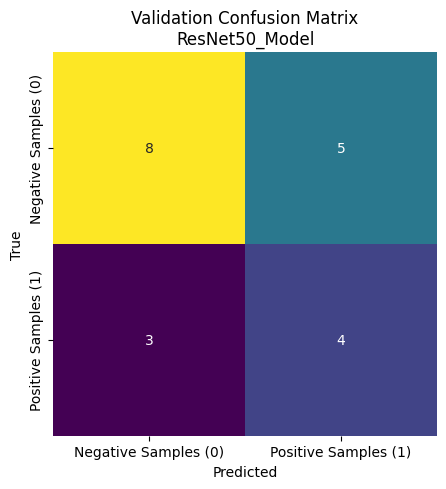

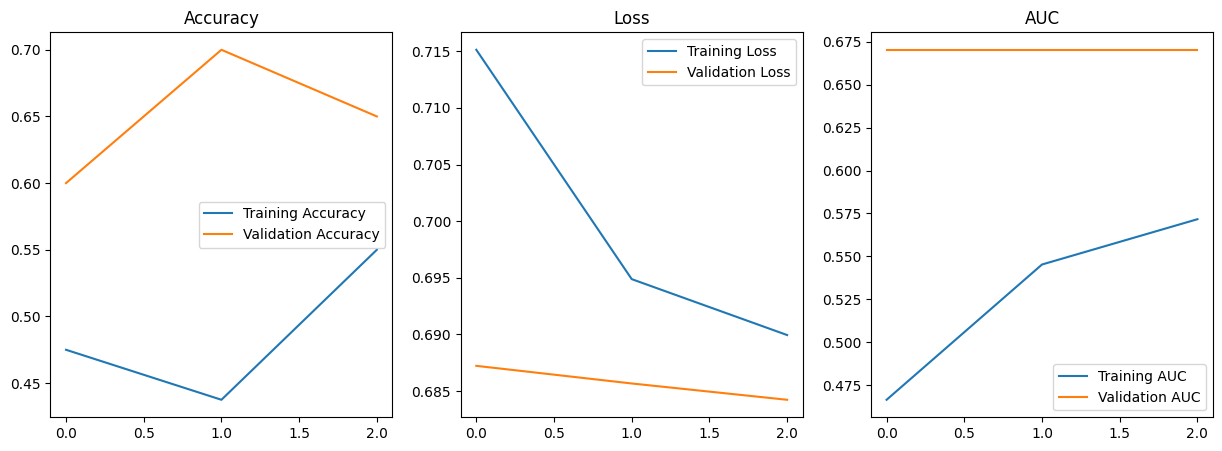

In [19]:
# Fit the ResNet50 transfer model
resnet_model_history = fit_CNN_model(
    resnet_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(resnet_model, resnet_model_history, val_ds)

#### DenseNet169 CNN Transfer Model

In [20]:
# DenseNet169 transfer model
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
densenet_model = build_transfer_model('DenseNet169_Model', densenet_model, dropout_rate=best_dropout_rate)
densenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)
densenet_model.summary()

Model: "DenseNet169_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 3, 3, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,644,545 (48.24 MB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

Loaded existing weights from ./best_model_weights/DenseNet169_Model_best_model.weights.h5
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - auc: 0.5037 - loss: 0.7039 - val_accuracy: 0.5500 - val_auc: 0.3736 - val_loss: 0.9547
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6375 - auc: 0.6214 - loss: 0.6757 - val_accuracy: 0.5500 - val_auc: 0.3736 - val_loss: 0.9535
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5125 - auc: 0.4986 - loss: 0.7065 - val_accuracy: 0.5500 - val_auc: 0.3736 - val_loss: 0.9525
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

ROC AUC: 0.37362637362637363

              precision    recall  f1-score   support

           0     0.6667    0.6154    0.6400        13
           1     0.3750    0.4286    0.4000         7

    accuracy                         0.5500        20
   macro avg     0.5208    0.5220    0.5200        20
weighted avg     0.5646    0.5500    0.5560        20



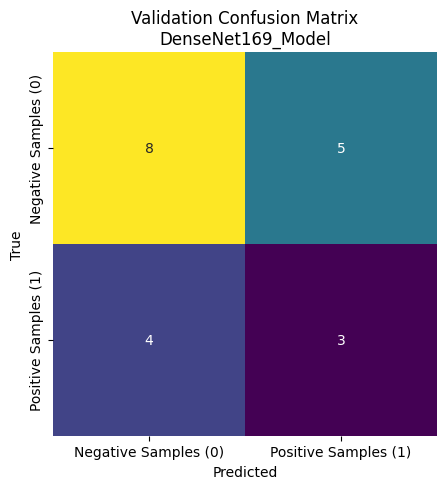

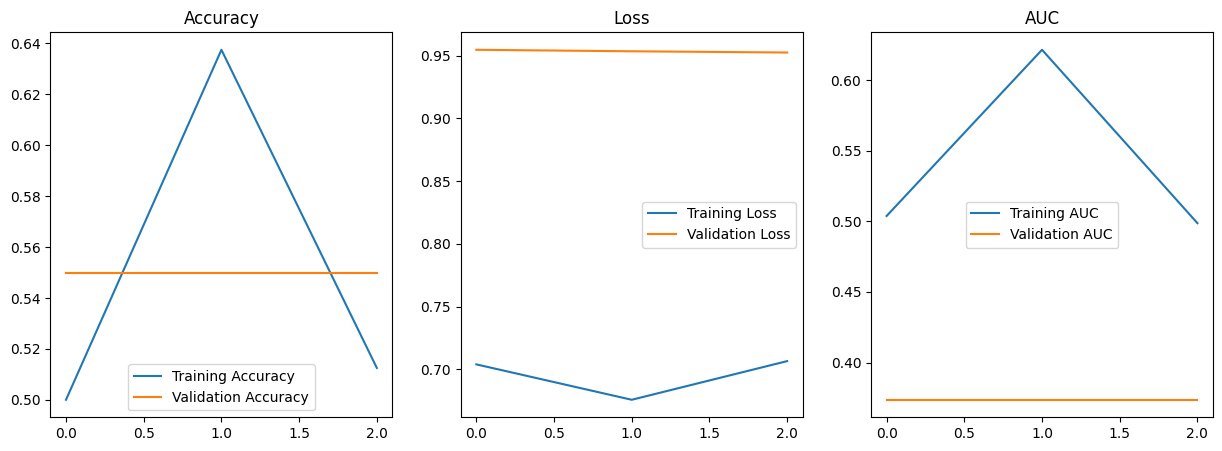

In [22]:
# Fit the DenseNet169 transfer model
DenseNet169_history = fit_CNN_model(
    densenet_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(densenet_model, DenseNet169_history, val_ds)

## Results & Analysis
After training the AUC and accuracy values for each model are:

| Model       | AUC   | Accuracy |
|-----------|-------|---------|
| ResNet34    | 0.9633 | 0.975   |
| ResNet50    | 0.9642 | 0.976   |
| VGG19      | 0.9473 | 0.965   |
| DenseNet169 | **0.9650** | **0.980** |

Analyze results...

#### Kaggle Submission

In [57]:
# Get best model
best_model = baseline_cnn_model

# Predict labels for test images

# Predict validation probabilites
test_probabilities = best_model.predict(test_ds, verbose=1).ravel()

# Convert probabilites to binary labels
test_predicted_labels = (test_probabilities >= 0.5).astype(np.int32)

# Extract ids from test_ids_list
pattern = re.compile(r'([a-f0-9]{40})(?=\.tif$)', re.IGNORECASE)
test_ids = [pattern.search(p).group(1) for p in test_ids_list if pattern.search(p)]

# Create submission_df
submission_df = pd.DataFrame({'id': test_ids, 'label': test_predicted_labels})
submission_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


,id,label
0,32bd8e44099092de51fe6a38cbe6636e4f523345,0
1,2b2d5dbef9ce9342496295111d9eca6ef27ece98,0
2,19de5177d519acb8498d9218a6059fe35b0d6636,1
3,f8ee9d11c486a7f79e2735b65775955767a93a09,0
4,33476e21b25c0c4117bcf192b164603eb03fc798,0
...,...,...
95,2d9655cefac4e2040a79908a86c6138674253254,0
96,66a84bc7614ccc82c67eb83c33fccde96ab458db,0
97,abb5b0dc93b45f8826f9141030be3d0716b3168b,0
98,e9728a165e69e42088ccc61495265ca1f8e04ccc,0


In [ ]:
# Image of Kaggle submission


## Conclusion
- Summarize project
- Learnings and takeaways
- What did and did not help improve the performance of your models
- What improvements could you try in the future